In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv('weekly_in_situ_co2_mlo.csv', header=None, parse_dates=[0], dtype={1: np.float16}, names=['date', 'level_ppm'])
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


<AxesSubplot:xlabel='date'>

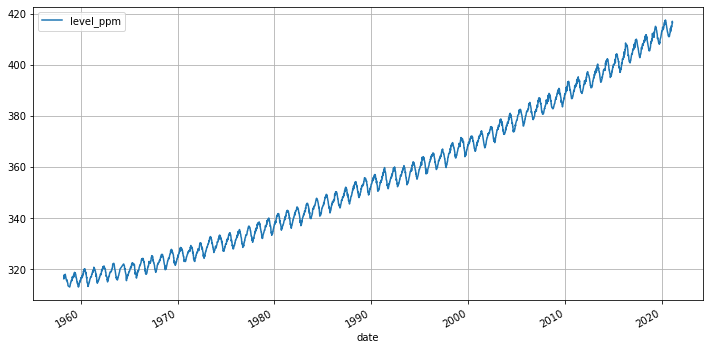

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)

In [6]:
df['timestamp'] = df['date'].apply(datetime.timestamp)
df.head()

,date,level_ppm,timestamp
0,1958-03-29,316.25,-371185200.0
1,1958-04-05,317.25,-370580400.0
2,1958-04-12,317.75,-369975600.0
3,1958-04-19,317.50,-369370800.0
4,1958-04-26,316.50,-368766000.0
